In [2]:
import pandas as pd
import datetime
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

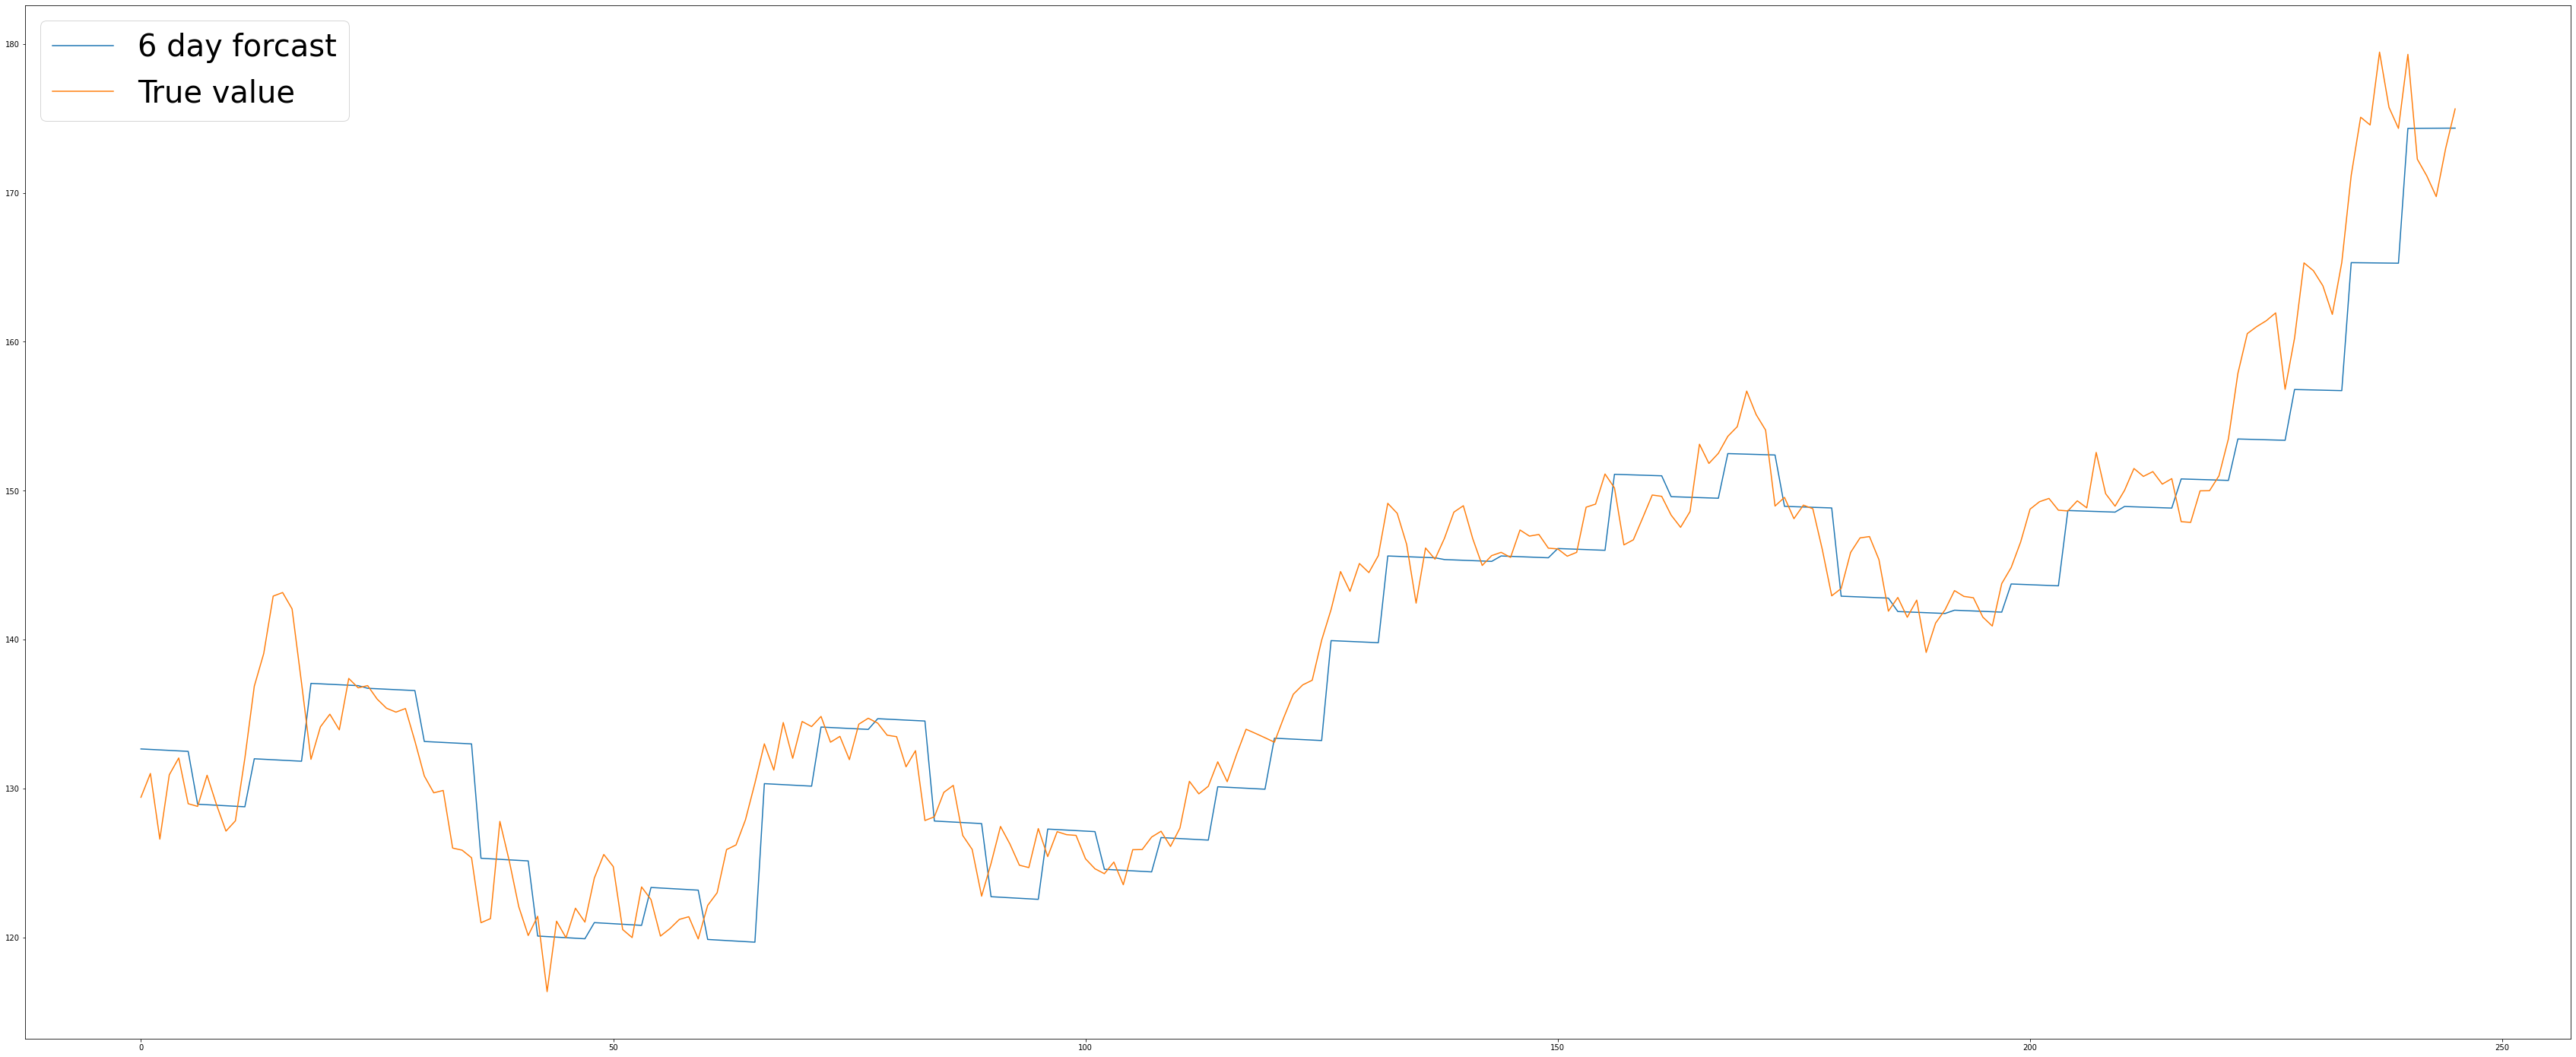

In [18]:
#here the model updates every n days which is not actually correct, the model should be updating every day we get new data
#here it is the case that we will be making to many predictions, we can see how our predictions change as we get knew data however. 
#we will see this in the slope difference trading strategy

df = pd.read_csv("../data/processed/appl_stock_values.csv")

#split the data
df["Date"] = pd.to_datetime(df["Date"])
df = df.drop(columns=["Open","Volume", "High", "Low", "Unnamed: 0"])
test = df[df["Date"] > datetime.datetime(2021, 1, 1)]
train = df[df["Date"] <= datetime.datetime(2021, 1, 1)]

lag_n_pred = []
date = []
n = 6
test = test.reset_index(drop=True)


for i in range(0,len(test),n):
    model = AutoReg(train["Close"], lags = 1, old_names=False)
    model_fit = model.fit()

    #store predictions for the next two days
    predictions = model_fit.predict(start=len(train), end=len(train) +n-1)
    for index in range(n):
        lag_n_pred.append(predictions.iloc[index])
    
    #update the model with two days worth of data
    for j in range(n):
        if(i+j < len(test)):
            train = train.append({"Close": test.iloc[i+j]["Close"], "Date":test.iloc[i+j]["Date"]}, ignore_index=True)

plt.figure(figsize=(60,25))
plt.plot(lag_n_pred, label = str(n)+" day forcast")
plt.plot(test["Close"], label = "True value")
plt.legend(loc="upper left", prop={'size': 40})
plt.show()

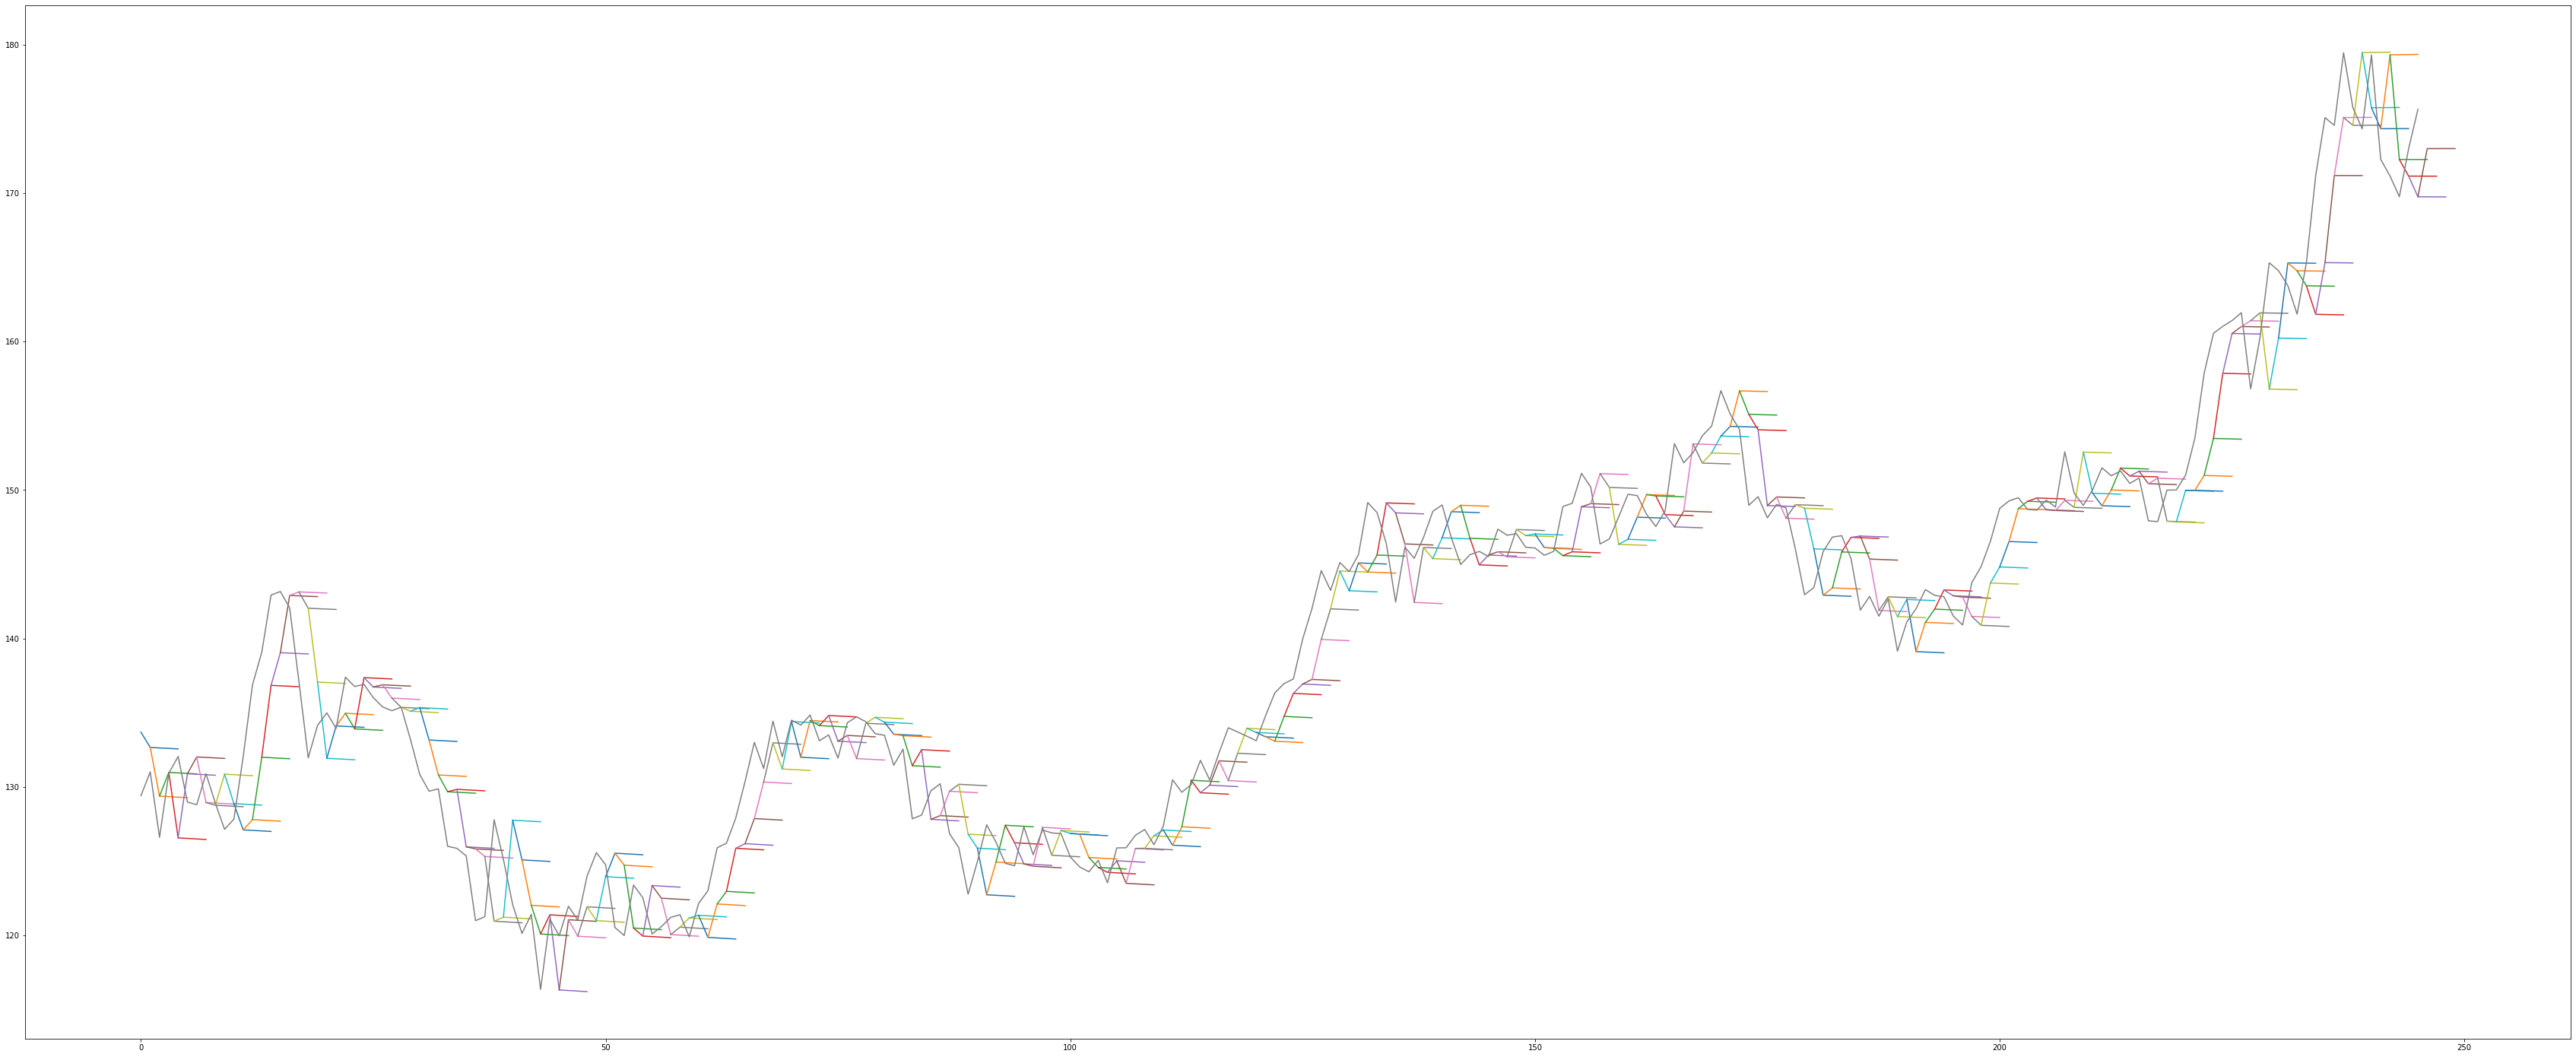

In [17]:
#we revise the above plot to show the difference of slopes trading strategy
#we see how our predictions change as we get new information to see what kind of trend we are in at the moment
#with using the difference of these slopes we can detece the strength of the trend
#one note is that here we do not use the actualy predicted values, we can even directly grab the value of the slope from the model
#here the model updates every n days which is not actually correct, the model should be updating every day we get new data
#here it is the case that we will be making to many predictions, we can see how our predictions change as we get knew data however. 
#we will see this in the slope difference trading strategy

df = pd.read_csv("../data/processed/appl_stock_values.csv")

#split the data
df["Date"] = pd.to_datetime(df["Date"])
df = df.drop(columns=["Open","Volume", "High", "Low", "Unnamed: 0"])
test = df[df["Date"] > datetime.datetime(2021, 1, 1)]
train = df[df["Date"] <= datetime.datetime(2021, 1, 1)]

temp = []
lag_n_pred = []
date = []
n = 3
test = test.reset_index(drop=True)
plt.figure(figsize=(60,25))

for i in range(0,len(test)):
    model = AutoReg(train["Close"], lags = 1, old_names=False)
    model_fit = model.fit()

    #store predictions for the next two days
    predictions = model_fit.predict(start=len(train)-1, end=len(train)+n)

    for index in range(2+n):
        temp.append(predictions.iloc[index])
    
    plt.plot([x for x in range(i,i+2+n)], temp)
    temp = []
    
    #update the model with two days worth of data

    train = train.append({"Close": test.iloc[i]["Close"], "Date":test.iloc[i]["Date"]}, ignore_index=True)

plt.plot(lag_n_pred, label = str(n)+" day ahead prediction")
plt.plot(test["Close"], label = "True value")
plt.show()


From this wacky graph we notice something interesting, we only have a real change from the current value to the next prediction, meaning that the difference of values between t and t +1 vary greatly, but after that t + 1 + n does not really change. Meaning there is a significant first difference, but the 1 +nth difference ~= 0

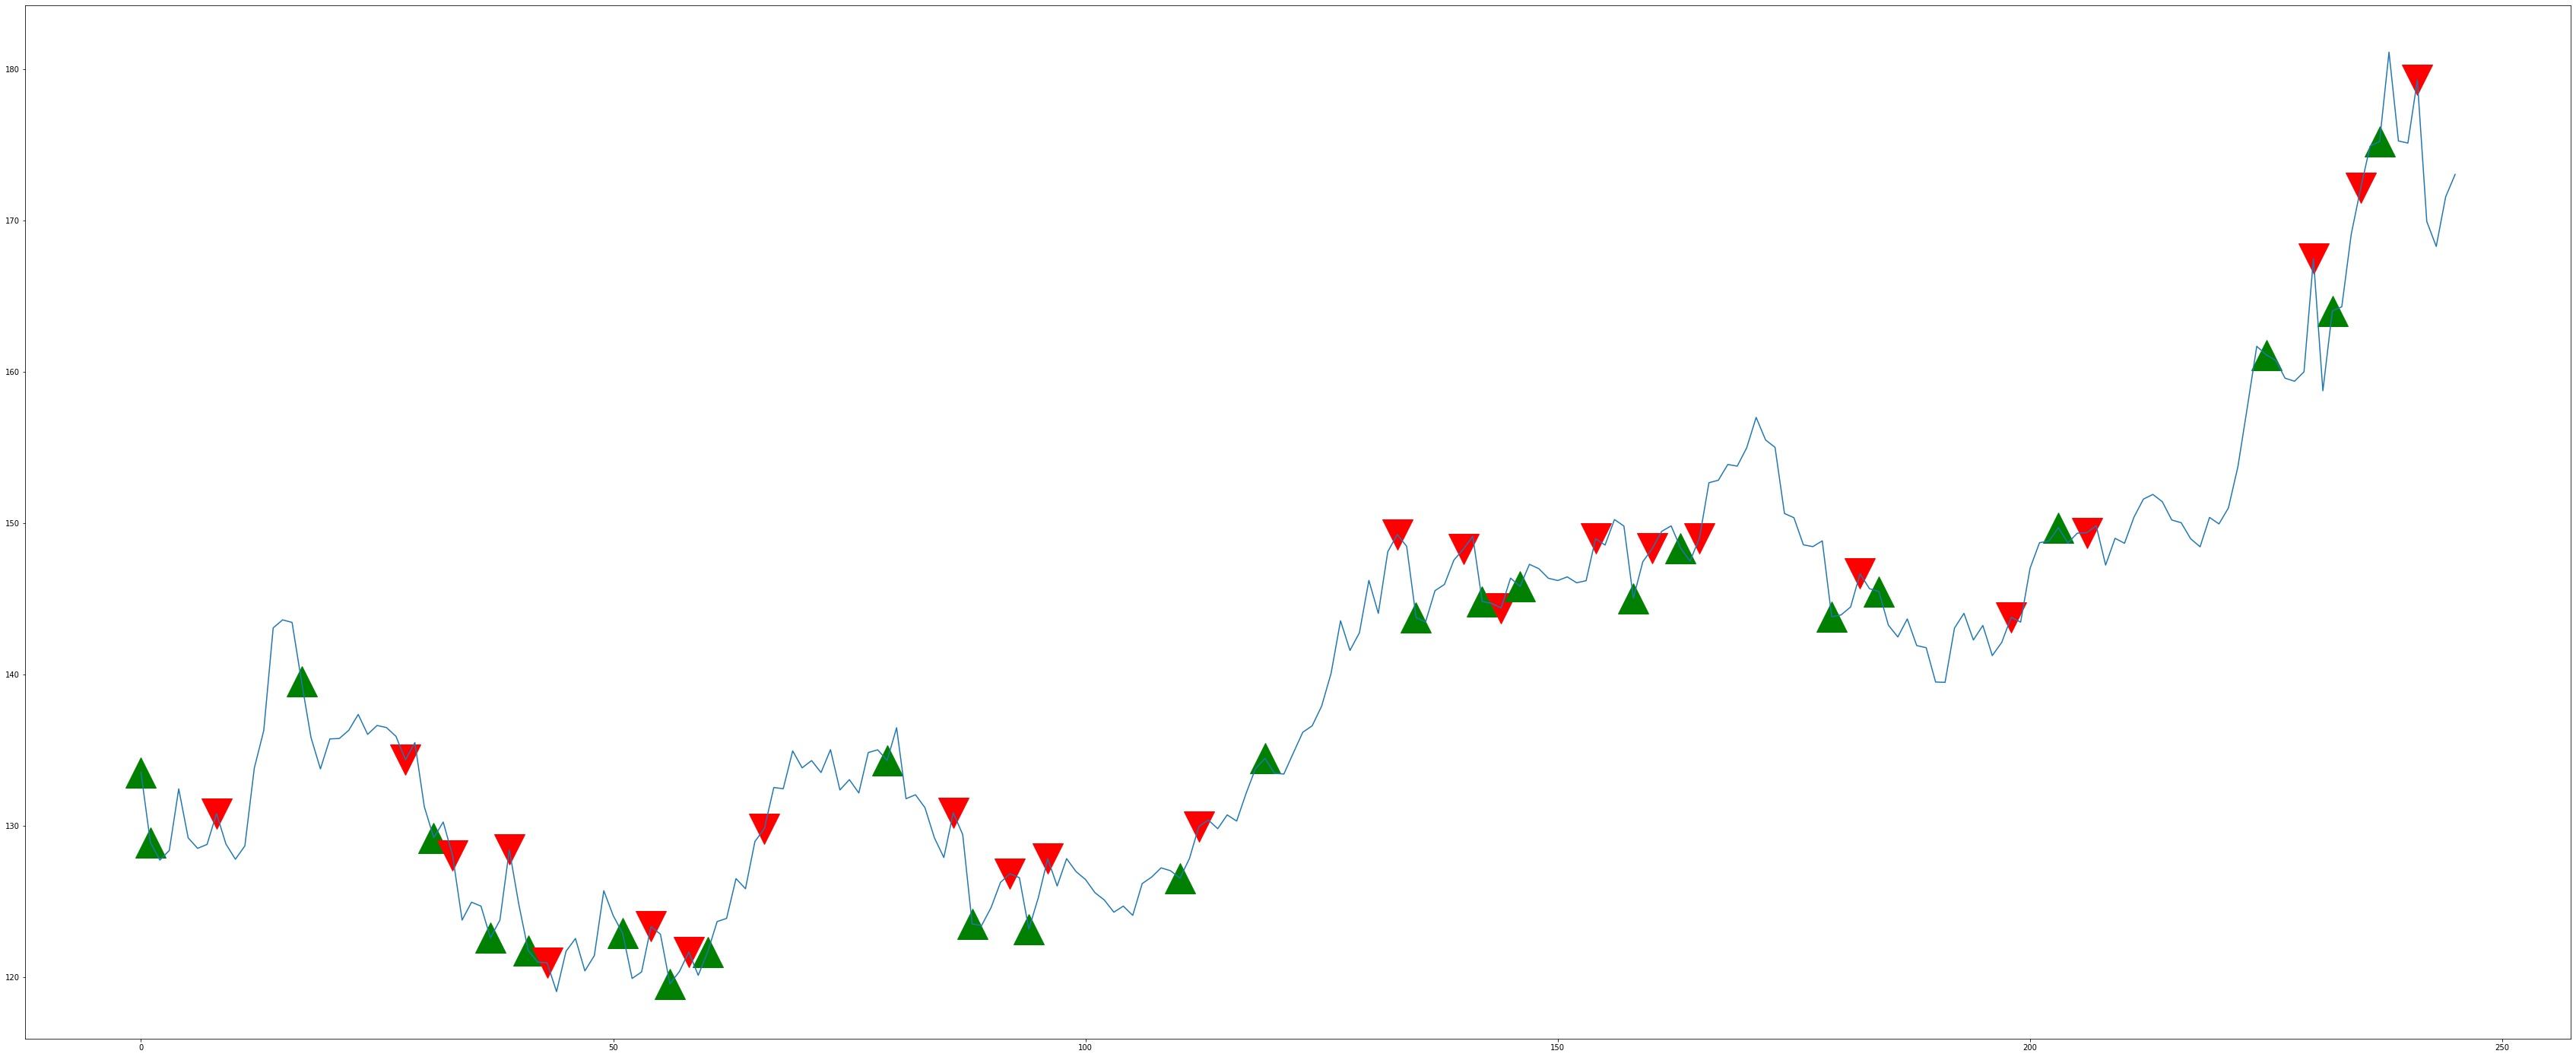

In [23]:
#So for our trend line trading strat we can do as follows. Using a time window of the three slopes of t-2 to t-1 and t-1 to t and t to t+1 
#if slope(t,t+1) > slope(t-1,t) > slope(t-2,t-1) we are in a strong uptrend
#if slope(t,t+1) < slope(t-1,t) < slope(t-2,t-1) we are in a strong downtrend
#if other then we are in a period of consolidation

#this is our purchase tracker
cash = 2000
starting = cash
equity = cash
holdings = 0
history = [] #[(amount, buy or sell , purchase price / sell price)]

df = pd.read_csv("../data/processed/appl_stock_values.csv")

#split the data
df["Date"] = pd.to_datetime(df["Date"])
df = df.drop(columns=["Volume", "High", "Low", "Unnamed: 0"])
test = df[df["Date"] > datetime.datetime(2021, 1, 1)]
train = df[df["Date"] <= datetime.datetime(2021, 1, 1)]
test = test.reset_index(drop=True)

window_len = 3
slope_window = []
sell_factor = 1 
equity_vals = []

plt.figure(figsize=(60,25))

for i in range(0,len(test)):
    model = AutoReg(train["Close"], lags = 1, old_names=False)
    model_fit = model.fit()

    #store predictions for the next two days
    predictions = model_fit.predict(start=len(train)-1, end=len(train))
    slope_window.append(predictions.iloc[1] - predictions.iloc[0])

    #make sure size is three
    if len(slope_window) > window_len:
        slope_window.pop(0)
    
    #check conditions
    buy = True
    sell = True

    if len(slope_window) == window_len:
        for slope_index in range(1, window_len):
            if slope_window[slope_index] < slope_window[slope_index-1]:
                sell = False
            if slope_window[slope_index] > slope_window[slope_index-1]:
                buy = False
    
    
    if buy:
        price = test.iloc[i]["Open"]
        
        if (cash // sell_factor) < price:
            amount = (cash // price)
        else:
            amount = ((cash/sell_factor) // price) 
        
        cash -= amount * price
        holdings += amount

        if amount != 0:
            history.append((amount, "buy", price))
            plt.plot([i],[price],marker = "^", color = "g",markersize=40)
        

    elif sell:
        price = test.iloc[i]["Open"]
        amount = (holdings // sell_factor)
        if amount == 0:
            amount = holdings

        holdings -= amount
        cash += amount * price
        
        if amount != 0:
            history.append((amount, "sell", price))
            plt.plot([i], [price], marker = "v", color = "r",markersize=40)
    
    
    
    #update the model with two days worth of data
    train = train.append({"Close": test.iloc[i]["Close"], "Date":test.iloc[i]["Date"]}, ignore_index=True)


    if holdings != 0:
        equity = cash + holdings * test.iloc[i]["Open"]
    else: 
        equity = cash
    
    equity_vals.append(equity)

plt.plot(test["Open"])



In [24]:
print(cash)
print(equity)
print(history)
print((equity - starting) / starting )


3008.430338999999
3008.430338999999
[(14.0, 'buy', 133.520004), (1.0, 'buy', 128.889999), (15.0, 'sell', 130.800003), (14.0, 'buy', 139.520004), (14.0, 'sell', 134.350006), (14.0, 'buy', 129.199997), (14.0, 'sell', 128.009995), (15.0, 'buy', 122.589996), (15.0, 'sell', 128.410004), (16.0, 'buy', 121.75), (16.0, 'sell', 120.93), (15.0, 'buy', 122.879997), (15.0, 'sell', 123.330002), (16.0, 'buy', 119.540001), (16.0, 'sell', 121.650002), (16.0, 'buy', 121.650002), (16.0, 'sell', 129.800003), (15.0, 'buy', 134.309998), (15.0, 'sell', 130.850006), (16.0, 'buy', 123.5), (16.0, 'sell', 126.82), (17.0, 'buy', 123.160004), (17.0, 'sell', 127.82), (17.0, 'buy', 126.529999), (17.0, 'sell', 129.940002), (16.0, 'buy', 134.449997), (16.0, 'sell', 149.240005), (17.0, 'buy', 143.75), (17.0, 'sell', 148.270004), (17.0, 'buy', 144.809998), (17.0, 'sell', 144.380005), (17.0, 'buy', 145.809998), (17.0, 'sell', 148.970001), (18.0, 'buy', 145.029999), (18.0, 'sell', 148.309998), (18.0, 'buy', 148.350006), 

3008.430338999999

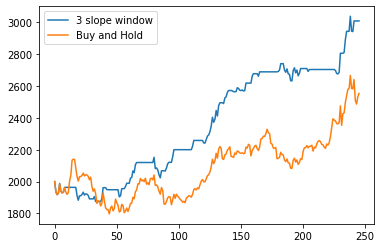

In [32]:
#plot an equity curve to see where we made and lost money
cash = 2000
holdings = cash // test.iloc[0]["Open"]
cash -= holdings * test.iloc[0]["Open"]
base_equity_vals = []

for i in range(len(test)):
    base_equity = cash + holdings * test.iloc[i]["Open"]
    base_equity_vals.append(base_equity)



plt.plot(equity_vals,label="3 slope window")
plt.plot(base_equity_vals,label="Buy and Hold")
plt.legend(loc="upper left")


equity
         


2262.7699999999995
0.13138499999999975


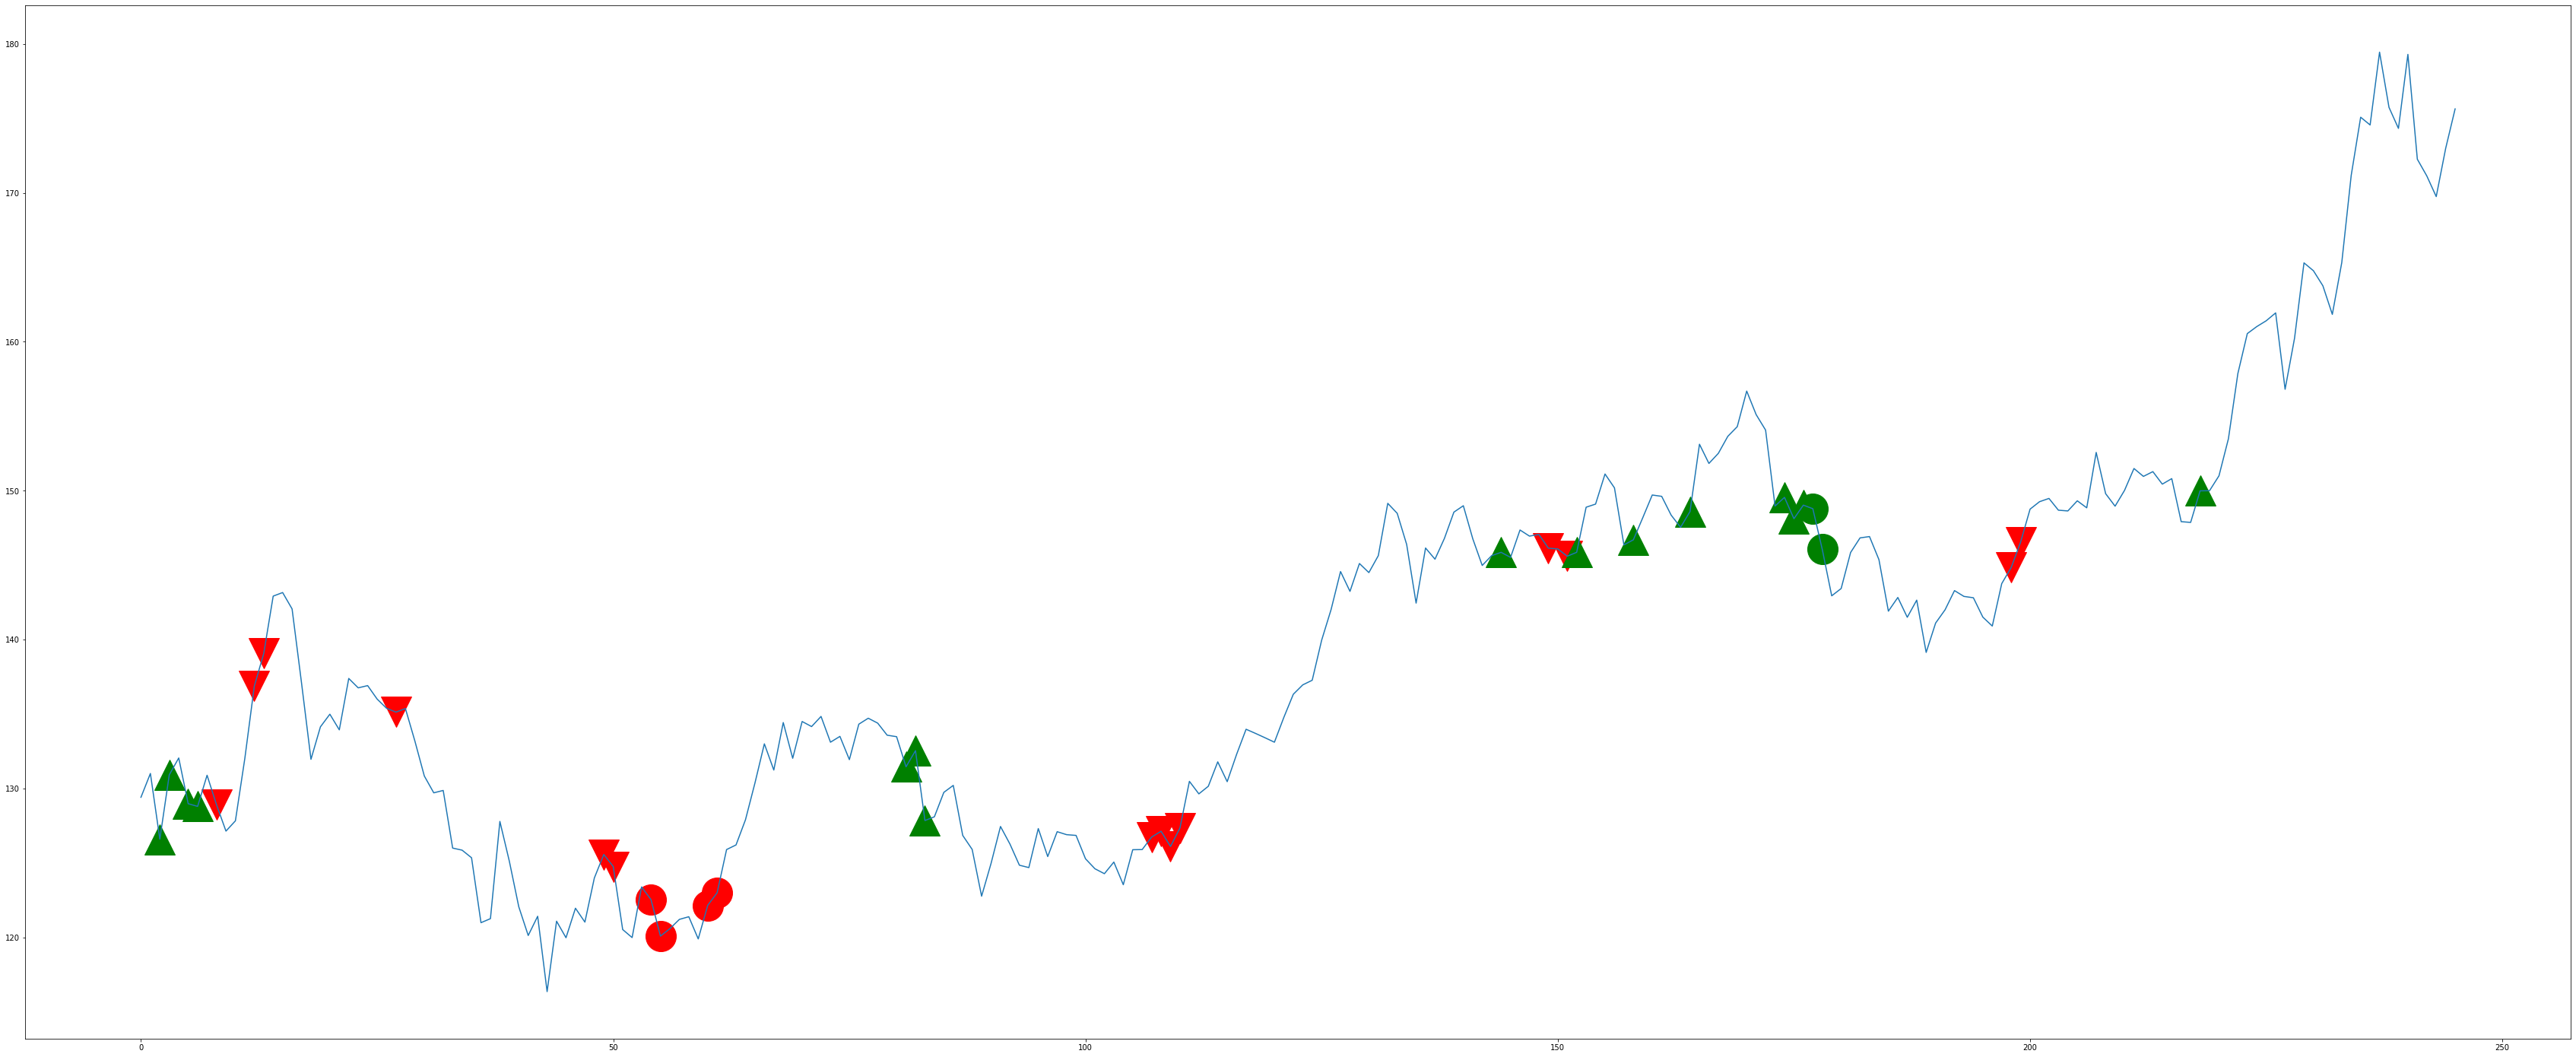

In [19]:

cash = 2000
starting = cash
equity = cash
holdings = 0
history = [] #[(amount, buy or sell , purchase price / sell price)]

df = pd.read_csv("../data/processed/appl_stock_values.csv")

#split the data
df["Date"] = pd.to_datetime(df["Date"])
df = df.drop(columns=["Volume", "High", "Low", "Unnamed: 0"])
test = df[df["Date"] > datetime.datetime(2021, 1, 1)]
train = df[df["Date"] <= datetime.datetime(2021, 1, 1)]

test_index_buffer = len(train)

df["MA19"] = df["Open"].rolling(19).mean()
df["MA9"] = df["Open"].rolling(9).mean()

test = test.reset_index(drop=True)
plt.figure(figsize=(60,25))

for i in range(0,len(test)):
    model = AutoReg(train["Open"], lags = 1, old_names=False)
    model_fit = model.fit()

    #store predictions for the next two days
    predictions = model_fit.predict(start=len(train), end=len(train))
    
    #we will use the 19 day moving average to calculate the 20 day SMA
    ma_19 = df.iloc[test_index_buffer + i]["MA19"]
    ma_20 = (ma_19 * 19 + predictions.iloc[0]) / 20

    ma_19_y = df.iloc[test_index_buffer + i - 1]["MA19"]
    ma_20_y = (ma_19_y * 19 + test.iloc[i]["Open"]) / 20

    #we will use the 9 day moving average to calculate the 10 day SMA
    ma_9 = df.iloc[test_index_buffer + i]["MA9"]
    ma_10 = (ma_9 * 9 + predictions.iloc[0]) / 10

    ma_9_y = df.iloc[test_index_buffer + i - 1]["MA19"]
    ma_10_y = (ma_9_y * 9 + test.iloc[i]["Open"]) / 10

    buy = False
    sell = False

    # buy
    if (ma_10 > ma_20) and (ma_10_y < ma_20_y):
        buy = True

    # sell
    elif (ma_10 < ma_20) and (ma_10_y > ma_20_y): 
        sell = True
    
    if buy:
        price = test.iloc[i]["Close"]
        
        if (cash // sell_factor) < price:
            amount = (cash // price)
        else:
            amount = ((cash/sell_factor) // price) 
        
        cash -= amount * price
        holdings += amount

        if amount != 0:
            history.append((amount, "buy", price))
            plt.plot([i],[price],marker = "^", color = "g",markersize=40)
        else:
            plt.plot([i], [price], marker = "o", color = "g",markersize=40)
        

    elif sell:
        price = test.iloc[i]["Close"]
        amount = (holdings // sell_factor)
        if amount == 0:
            amount = holdings

        holdings -= amount
        cash += amount * price
        
        if amount != 0:
            history.append((amount, "sell", price))
            plt.plot([i], [price], marker = "v", color = "r",markersize=40)
        else:
            plt.plot([i], [price], marker = "o", color = "r",markersize=40)
            

    
    #update the model with two days worth of data
    train = train.append({"Open": test.iloc[i]["Open"], "Date":test.iloc[i]["Date"]}, ignore_index=True)


if holdings != 0:
    equity = cash + holdings * test.iloc[len(test)-1]["Close"]
else: 
    equity = cash

print(equity)
print((equity - starting)/ starting)
plt.plot(test["Close"])
plt.show()


2030.2575573846152

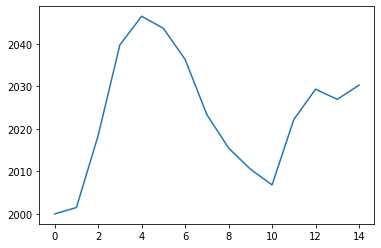

In [20]:
#plot an equity curve to see where we made and lost money
equity = 2000
equity_vals = [equity]
running_holding_value = 0
num_holdings = 0
avg_price = 0


for i in range(len(history)-1):
    if history[i][1] == "buy":
        running_holding_value += history[i][2] * history[i][0]
        num_holdings += history[i][0]
        
    else: #we are selling
        avg_price = running_holding_value / num_holdings

        
        num_holdings -= history[i][0]
        running_holding_value -= avg_price * history[i][0]

        
        equity += (history[i][2] - avg_price) * history[i][0]
        equity_vals.append(equity)


plt.plot(equity_vals)

equity

2398.8700739999986
0.1994350369999993


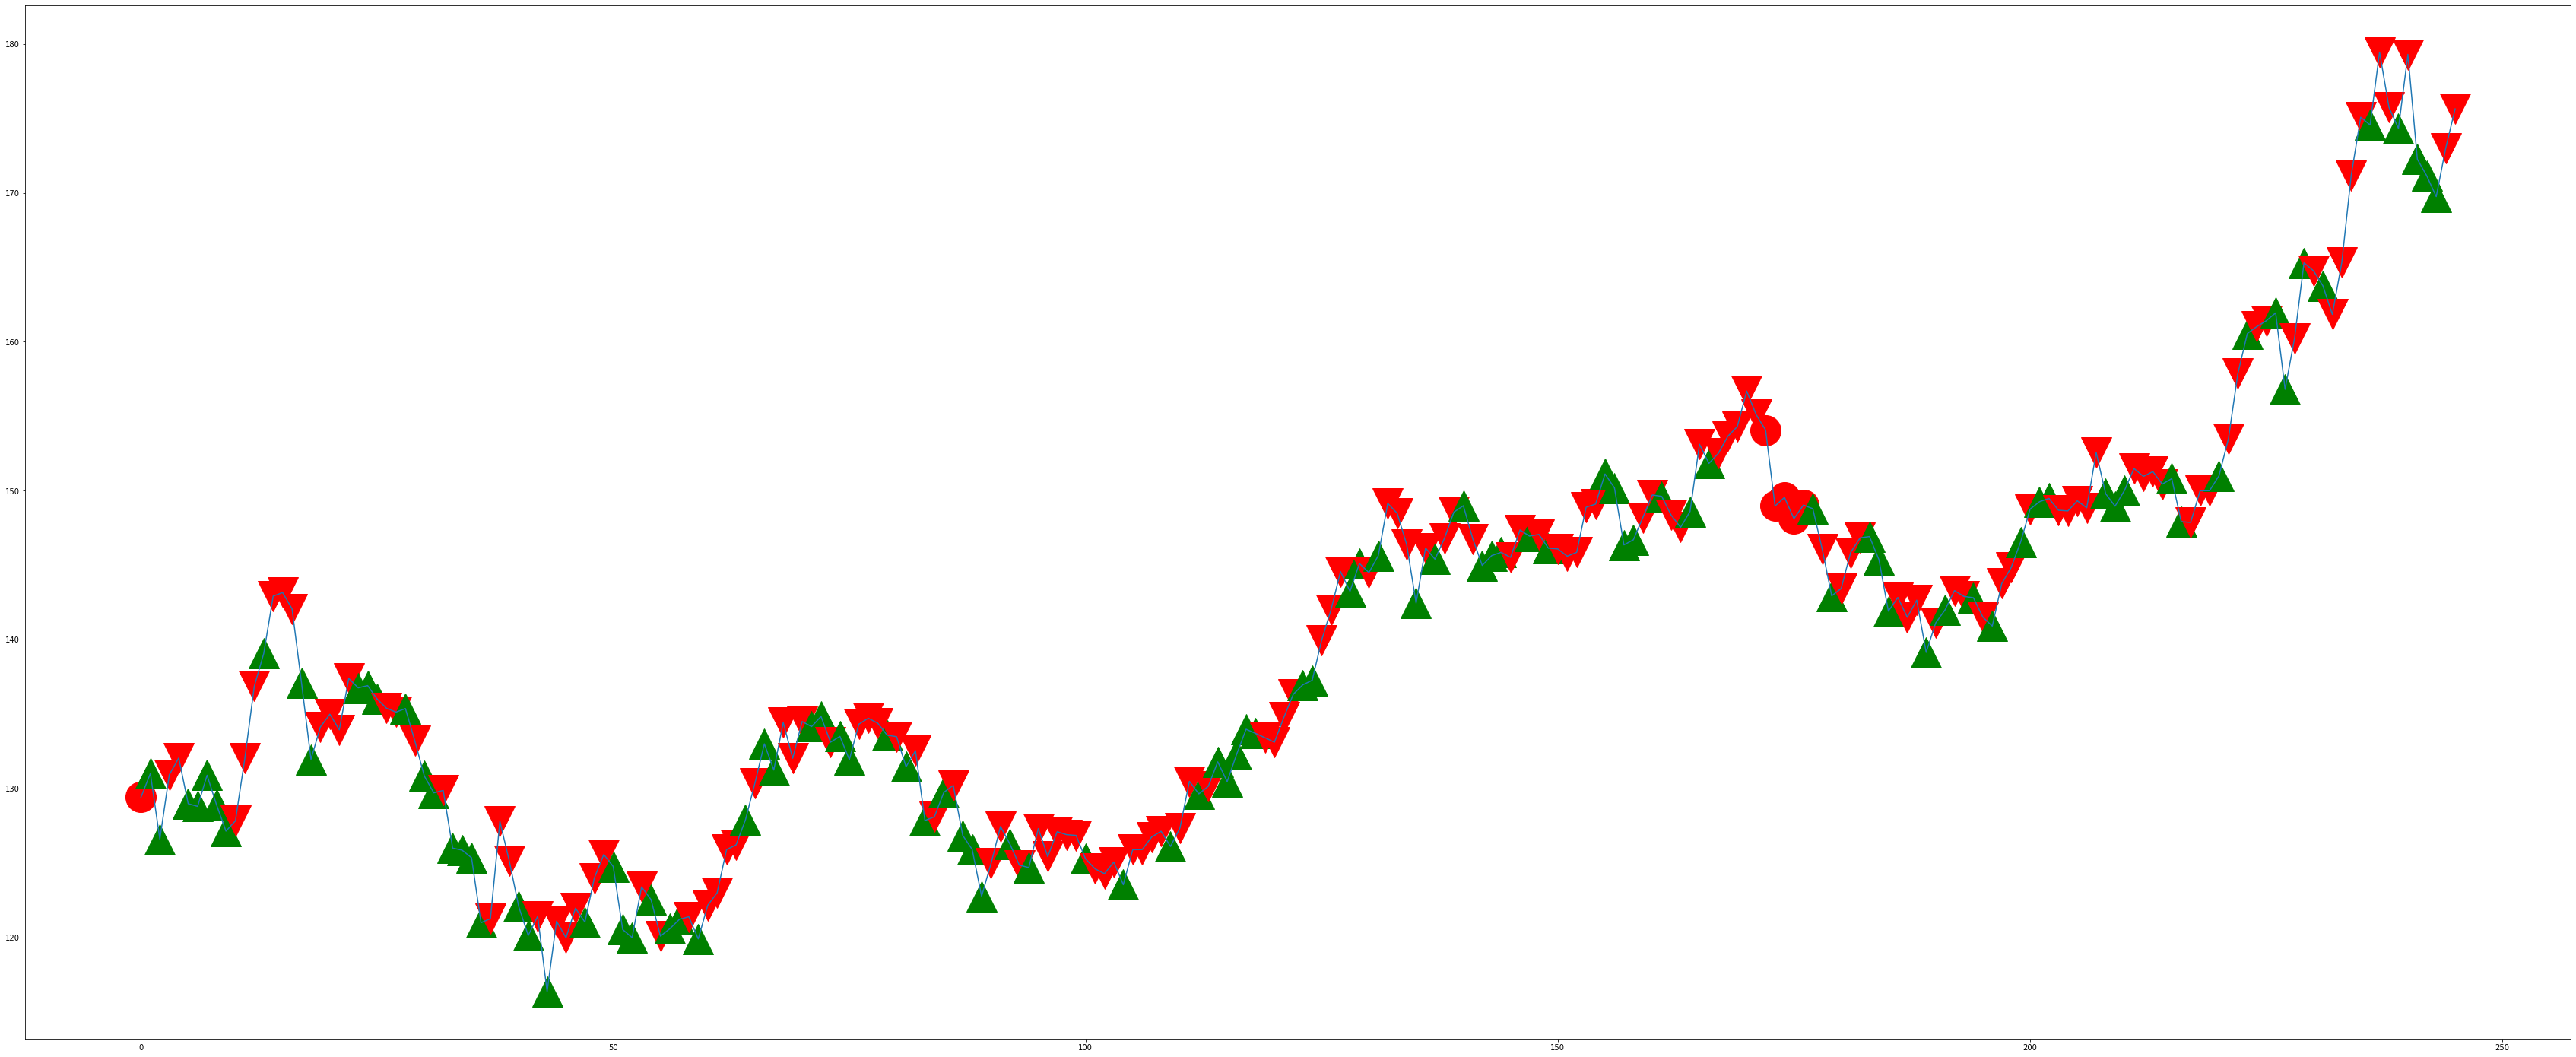

In [35]:
#Our last test is the simple buy forcast stragy, if tommorows price is greater than todays price we buy, else we sell or even short
#NOTES: the model is buying + selling to early. Since the price moves in a given day are not 
cash = 2000
starting = cash
equity = cash
holdings = 0
history = [] #[(amount, buy or sell , purchase price / sell price)]

df = pd.read_csv("../data/processed/appl_stock_values.csv")

#split the data
df["Date"] = pd.to_datetime(df["Date"])
df = df.drop(columns=["Volume", "High", "Low", "Unnamed: 0"])
test = df[df["Date"] > datetime.datetime(2021, 1, 1)]
train = df[df["Date"] <= datetime.datetime(2021, 1, 1)]

equity_vals = [equity]
sell_factor = 3
test = test.reset_index(drop=True)
plt.figure(figsize=(60,25))

for i in range(0,len(test)):
    model = AutoReg(train["Close"], lags = 1, old_names=False)
    model_fit = model.fit()

    #store predictions for the next two days
    buy = False
    sell = False
    predictions = model_fit.predict(start=len(train), end=len(train))
    if test.iloc[i]["Open"] < predictions.iloc[0]:
        buy = True
    else:
        sell = True

    
    if buy:
        price = test.iloc[i]["Close"]
        
        if (cash // sell_factor) < price:
            amount = (cash // price)
        else:
            amount = ((cash/sell_factor) // price) 
        
        cash -= amount * price
        holdings += amount

        if amount != 0:
            history.append((amount, "buy", price))
            plt.plot([i],[price],marker = "^", color = "g",markersize=40)
        else:
            plt.plot([i], [price], marker = "o", color = "g",markersize=40)
        

    elif sell:
        price = test.iloc[i]["Close"]
        amount = (holdings // sell_factor)
        if amount == 0:
            amount = holdings

        holdings -= amount
        cash += amount * price
        
        if amount != 0:
            history.append((amount, "sell", price))
            plt.plot([i], [price], marker = "v", color = "r",markersize=40)
        else:
            plt.plot([i], [price], marker = "o", color = "r",markersize=40)
            

    
    #update the model with two days worth of data

    train = train.append({"Close": test.iloc[i]["Close"], "Date":test.iloc[i]["Date"]}, ignore_index=True)

    if holdings != 0:
        equity = cash + holdings * test.iloc[len(test)-1]["Close"]
    else: 
        equity = cash
    
    equity_vals.append(equity)

print(equity)
print((equity - starting)/ starting)
plt.plot(test["Close"])
plt.show()


2398.8700739999986

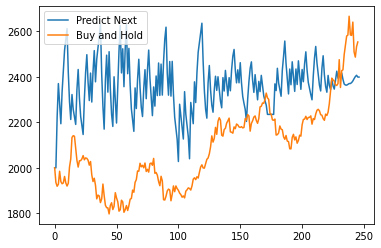

In [37]:
#plot an equity curve to see where we made and lost money
cash = 2000
holdings = cash // test.iloc[0]["Open"]
cash -= holdings * test.iloc[0]["Open"]
base_equity_vals = []

for i in range(len(test)):
    base_equity = cash + holdings * test.iloc[i]["Open"]
    base_equity_vals.append(base_equity)



plt.plot(equity_vals,label="Predict Next")
plt.plot(base_equity_vals,label="Buy and Hold")
plt.legend(loc="upper left")


equity